# Doppler Count and Range-Rate Observations

In [1]:
# import dsoclasses
import datetime
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
# import modules for plotting ...
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

We will need to files for the following:
 - a DORIS RINEX file, and
 - the corresponding sp3 file, holding tabulated satellite trajectory covering the RINEX observation interval

In [2]:
drinex = "../../data/s6arx24001.001"
dsp3 = "../../data/ssas6a20.b23357.e24001.DG_.sp3.001"

We will construct an `OrbitInterpolator` instance, based on the input sp3 file, to be able to retrieve satellite state (position and velocity) at any requested epoch using cubic spline interpolation.

In [3]:
sp3 = sp3c.Sp3(dsp3)
# set the id of the satellite we need; it should be the first (and only) satellite in the sp3 list
satid = sp3.sat_ids[0]
# extract its data
sp3_data = sp3.get_satellite(satid, True)
# construct an Interpolator
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

Create a `DorisRinex` instance and select the beacon of choice (Dionysos/DIOB).

In [4]:
# DORIS RINEX instance
rnx = DorisRinex(drinex)

# Διαλέγουμε τον σταθμό επιλογής
diob = 'D31'

## Retrieve L1 phase observables

As before, we can loop through the RINEX file and extract L1 phase measurements (given in L1 cycles).

In [5]:
# store observations and corresponding epochs
t = []; L1 = [];

for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            t.append(block.t())
            L1.append(data['L1']['value'])

Let's see how the L1 measurements look like ...

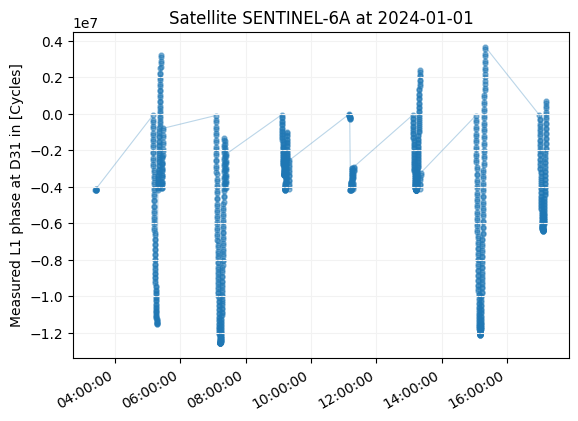

In [6]:
# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter([at2pt(ti) for ti in t], L1, alpha=0.5, s=12)
plt.plot([at2pt(ti) for ti in t], L1, alpha=0.3, linewidth=.8)

plt.grid(color='0.95')
plt.ylabel(f"Measured L1 phase at {diob} in [Cycles]")
plt.title(f"Satellite {rnx.sat_name} at {t[0].strftime('%Y-%m-%d')}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

## Extract L1 Doppler Count

Doppler Count is the ratio of the difference of two successive phase measurements (on the same frequency) divided by the corresponding time interval. Since we have already retrieved the L1 phase observables, we can compute the corresponding Doppler Counts:

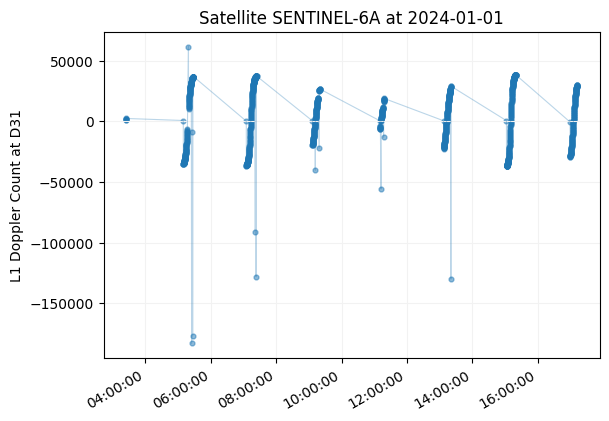

In [7]:
# Doppler Count and corresponding epochs
Ndop = []; tn = [];

# compute Doppler Count ...
for idx, ti in enumerate(t[0:-1]):
    Ndop.append((L1[idx+1] - L1[idx]) / float((t[idx+1] - t[idx]).total_seconds()))
    tn.append(t[idx+1])

# plot results
plt.scatter([at2pt(ti) for ti in tn], Ndop, alpha=0.5, s=12)
plt.plot([at2pt(ti) for ti in tn], Ndop, alpha=0.3, linewidth=.8)

plt.grid(color='0.95')
plt.ylabel(f"L1 Doppler Count at {diob}")
plt.title(f"Satellite {rnx.sat_name} at {tn[0].strftime('%Y-%m-%d')}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

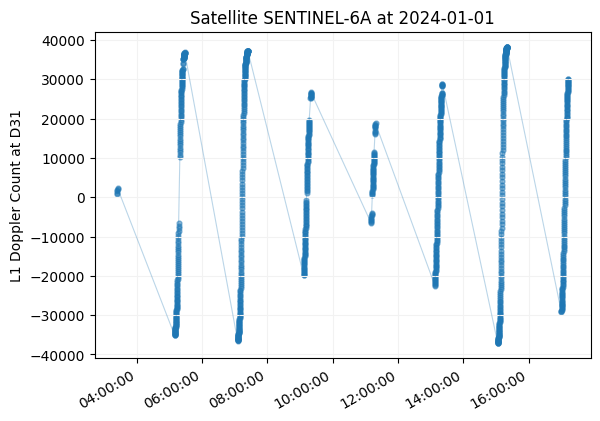

In [8]:
# we can do a bit better, 
# ... should probably remove intervals > 10 sec (DORIS performs observations every 3 and 7 sec)
Ndop = []; tn = [];
for idx, ti in enumerate(t[0:-1]):
    if (t[idx+1] - t[idx]).total_seconds() < 10.:
        Ndop.append((L1[idx+1] - L1[idx]) / float((t[idx+1] - t[idx]).total_seconds()))
        tn.append(t[idx+1])

# plot results
plt.scatter([at2pt(ti) for ti in tn], Ndop, alpha=0.5, s=12)
plt.plot([at2pt(ti) for ti in tn], Ndop, alpha=0.3, linewidth=.8)

plt.grid(color='0.95')
plt.ylabel(f"L1 Doppler Count at {diob}")
plt.title(f"Satellite {rnx.sat_name} at {tn[0].strftime('%Y-%m-%d')}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

## Skyplot (Doppler Count)

We can create the skyplot of the satellite, w.r.t  the beacon of choice. Approximate beacon coordinates are:

In [9]:
DIOB_xyz = np.array([4595220.016, 2039434.081, 3912626.007])

Transform to geodetic and compute the topocentric rotation matrix.

In [10]:
lat, lon, hgt = transformations.car2ell(*DIOB_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

We seem to have several passes over the beacon, each one should be plotted with a different color.

In [11]:
c=['red','green','blue','black','orange', 'olive', 'pink', 'purple', 'brown', 'gray']

Let's store horizon entry points (azimouth, elevation and time) so that we can mark them on the skyplot.

In [12]:
entries_az = []; entries_el = []; entries_t = [];
last_elevation_was = -np.pi

Ok, now loop through the sp3 tabulated positions, compute elevation and azimouth, mark entry points and make the plot!

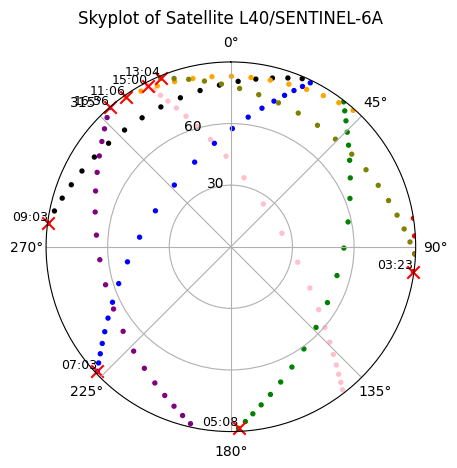

In [13]:
# data to plot (different colors for each pass)
azs = []; els = []; colors = [];
# current color index
color_idx = -1

# for every tabulated satellite position in the sp3 file...
for k, v in sp3_data.items():
    # filter out irrelevant dates ...
    if k >= at2pt(rnx.time_first_obs) and k<at2pt(rnx.time_first_obs)+datetime.timedelta(hours=24):
        # beacon to satellite vector
        dr = np.array([v['x'], v['y'], v['z']]) - DIOB_xyz
        # get topocentric coordinates
        enu = R @ dr
        # compute range, azimouth and elevation
        r  = np.linalg.norm(enu)
        az = np.arctan2(enu[0], enu[1])
        el = np.arcsin(enu[2] / r)
        # are we seeing the satellite ?
        if el >= 0:
            azs.append(az)
            els.append(90e0 - np.degrees(el))
            colors.append(c[color_idx])
        # is this a new pass ?
        if last_elevation_was <= 0 and el > 0:
            entries_az.append(az)
            entries_el.append(90e0 - np.degrees(el))
            entries_t.append(k)
            color_idx += 1
            colors[-1] = c[color_idx]
        last_elevation_was = el

# Create the skyplot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# position markers
ax.scatter(azs, els, c=colors, s=8)
# mark entry points with 'x'
ax.scatter(entries_az, entries_el, marker='x', c='red', s=80, clip_on=False)
# time of entry
for i in range(len(entries_t)):
    ax.text(entries_az[i], entries_el[i], entries_t[i].strftime("%H:%M"),
    fontsize=9, ha='right', va='bottom', clip_on=False)
ax.set_rmax(90)
ax.set_rticks([30, 60])
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# Rotate the angle axis by -90 degrees (make 0 degrees point up)
ax.set_theta_zero_location('N')  # Set 0 to the top (North)
ax.set_theta_direction(-1)  # Make the angles increase clockwise

ax.set_title(f"Skyplot of Satellite {satid}/{rnx.sat_name}", va='bottom')
plt.show()

## GroundTrack - Which part of the trajectory are we observing ?

Groundtrack is essentially the projection of the satellite trajectory on a map. Using the sp3 file we can plot the groundtrack, and keep track of the part we can observe from the beacon (assuming a totalyy clear horizon).

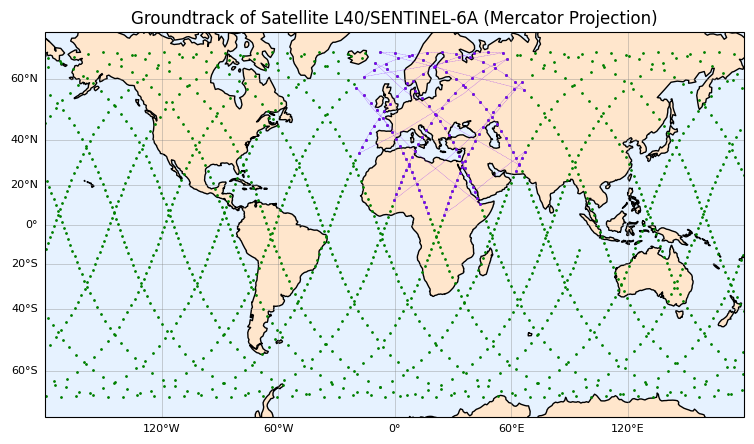

In [22]:
# groundtrack

# deprecated
# from mpl_toolkits.basemap import Basemap
# Note: Basemap is deprecated and no longer maintained. We can use Cartopy instead, 
# which is actively developed and supports modern NumPy/Matplotlib.
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lons = []; lats = [];
observed_lons = []; observed_lats = [];
for k,v in sp3_data.items():
        if k >= at2pt(rnx.time_first_obs) and k<at2pt(rnx.time_first_obs)+datetime.timedelta(hours=24):
            phi, lamda, _ = transformations.car2ell(v['x'], v['y'], v['z'])
            lons.append(lamda); lats.append(phi);
            # beacon to satellite vector
            dr = np.array([v['x'], v['y'], v['z']]) - DIOB_xyz
            # get topocentric coordinates
            enu = R @ dr
            r  = np.linalg.norm(enu)
            el = np.arcsin(enu[2] / r)
            if np.degrees(el) >= 0:
                observed_lons.append(lamda); observed_lats.append(phi);

# Create the Mercator projection
proj = ccrs.Mercator()

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=proj)

# Set map extent: (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

# Add map features
ax.coastlines(resolution='110m')  # '110m' = crude
ax.add_feature(cfeature.LAND, facecolor='#ffe6cc')
# ax.add_feature(cfeature.LAKES, facecolor='aqua')
ax.add_feature(cfeature.OCEAN, facecolor='#e6f2ff')

# Gridlines (parallels and meridians)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.top_labels = gl.right_labels = False  # only show left and bottom labels
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# Convert and plot satellite positions
deg_lons = np.degrees(lons)
deg_lats = np.degrees(lats)
ax.plot(deg_lons, deg_lats, 'go', markersize=1, transform=ccrs.PlateCarree())

deg_obs_lons = np.degrees(observed_lons)
deg_obs_lats = np.degrees(observed_lats)
ax.plot(
    deg_obs_lons,
    deg_obs_lats,
    marker='o',
    linestyle='--',
    linewidth=.2,
    markersize=1,
    color='#8000ff',
    transform=ccrs.PlateCarree()
)

# Title
plt.title(f"Groundtrack of Satellite {satid}/{rnx.sat_name} (Mercator Projection)")

plt.show()